# Compute median non-rearing pose for all individuals across ages to identify morphological changes across life

In [1]:
import h5py
import joblib
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from toolz import keyfilter, merge_with, valmap, groupby, curry, frequencies, merge
from aging.organization.paths import get_experiment_grouped_files, TrainingPaths
from aging.organization.dataframes import get_age
from aging.plotting import figure, format_plots

In [2]:
format_plots()

In [3]:
training_paths = TrainingPaths()
training_paths.tps_training_data.parent.mkdir(exist_ok=True, parents=True)

In [4]:
@curry
def not_double(parent_counts, path):
    if "jackson" not in str(path) and parent_counts[str(path.parents[1])] > 1:
        return 'proc_cleaned' == path.parent.name
    return True


In [5]:
exp_groups = get_experiment_grouped_files()

In [6]:
ont_files = keyfilter(lambda x: 'ontogeny_male' in x, exp_groups)
ont_files = valmap(curry(groupby)(get_age), ont_files)
ont_files = merge_with(curry(sum)(start=[]), *ont_files.values())
parent_counts = valmap(lambda files: frequencies(str(f.parents[1]) for f in files), ont_files)
parent_counts = merge(*parent_counts.values())
not_double_curried = not_double(parent_counts)
ont_files = valmap(lambda files: list(filter(not_double_curried, files)), ont_files)

In [7]:
age_templates = {}
for age, files in tqdm(ont_files.items()):
    templates = {}
    for file in tqdm(files, leave=False):
        try:
            with h5py.File(file, 'r') as h5f:
                frames = h5f['frames'][()]
            mask = frames > 10
            avg_height = np.sum(frames * mask, axis=(1, 2)) / (np.sum(mask, axis=(1, 2)) + 1)
            avg_height = pl.Series(avg_height)
            avg_height = avg_height - avg_height.quantile(0.1)
            thresh = avg_height.std() * 1.3
            keep_frames = frames[avg_height < thresh]
            # make 5 frames
            for i, idx in enumerate(np.array_split(np.random.permutation(len(keep_frames)), 6)):
                med_frame = np.median(keep_frames[idx], axis=0)
                med_frame[med_frame < 5] = 0
                templates[(file, i)] = med_frame
        except OSError:
            continue
    age_templates[age] = templates
    joblib.dump(age_templates, training_paths.tps_training_data, compress=3)

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

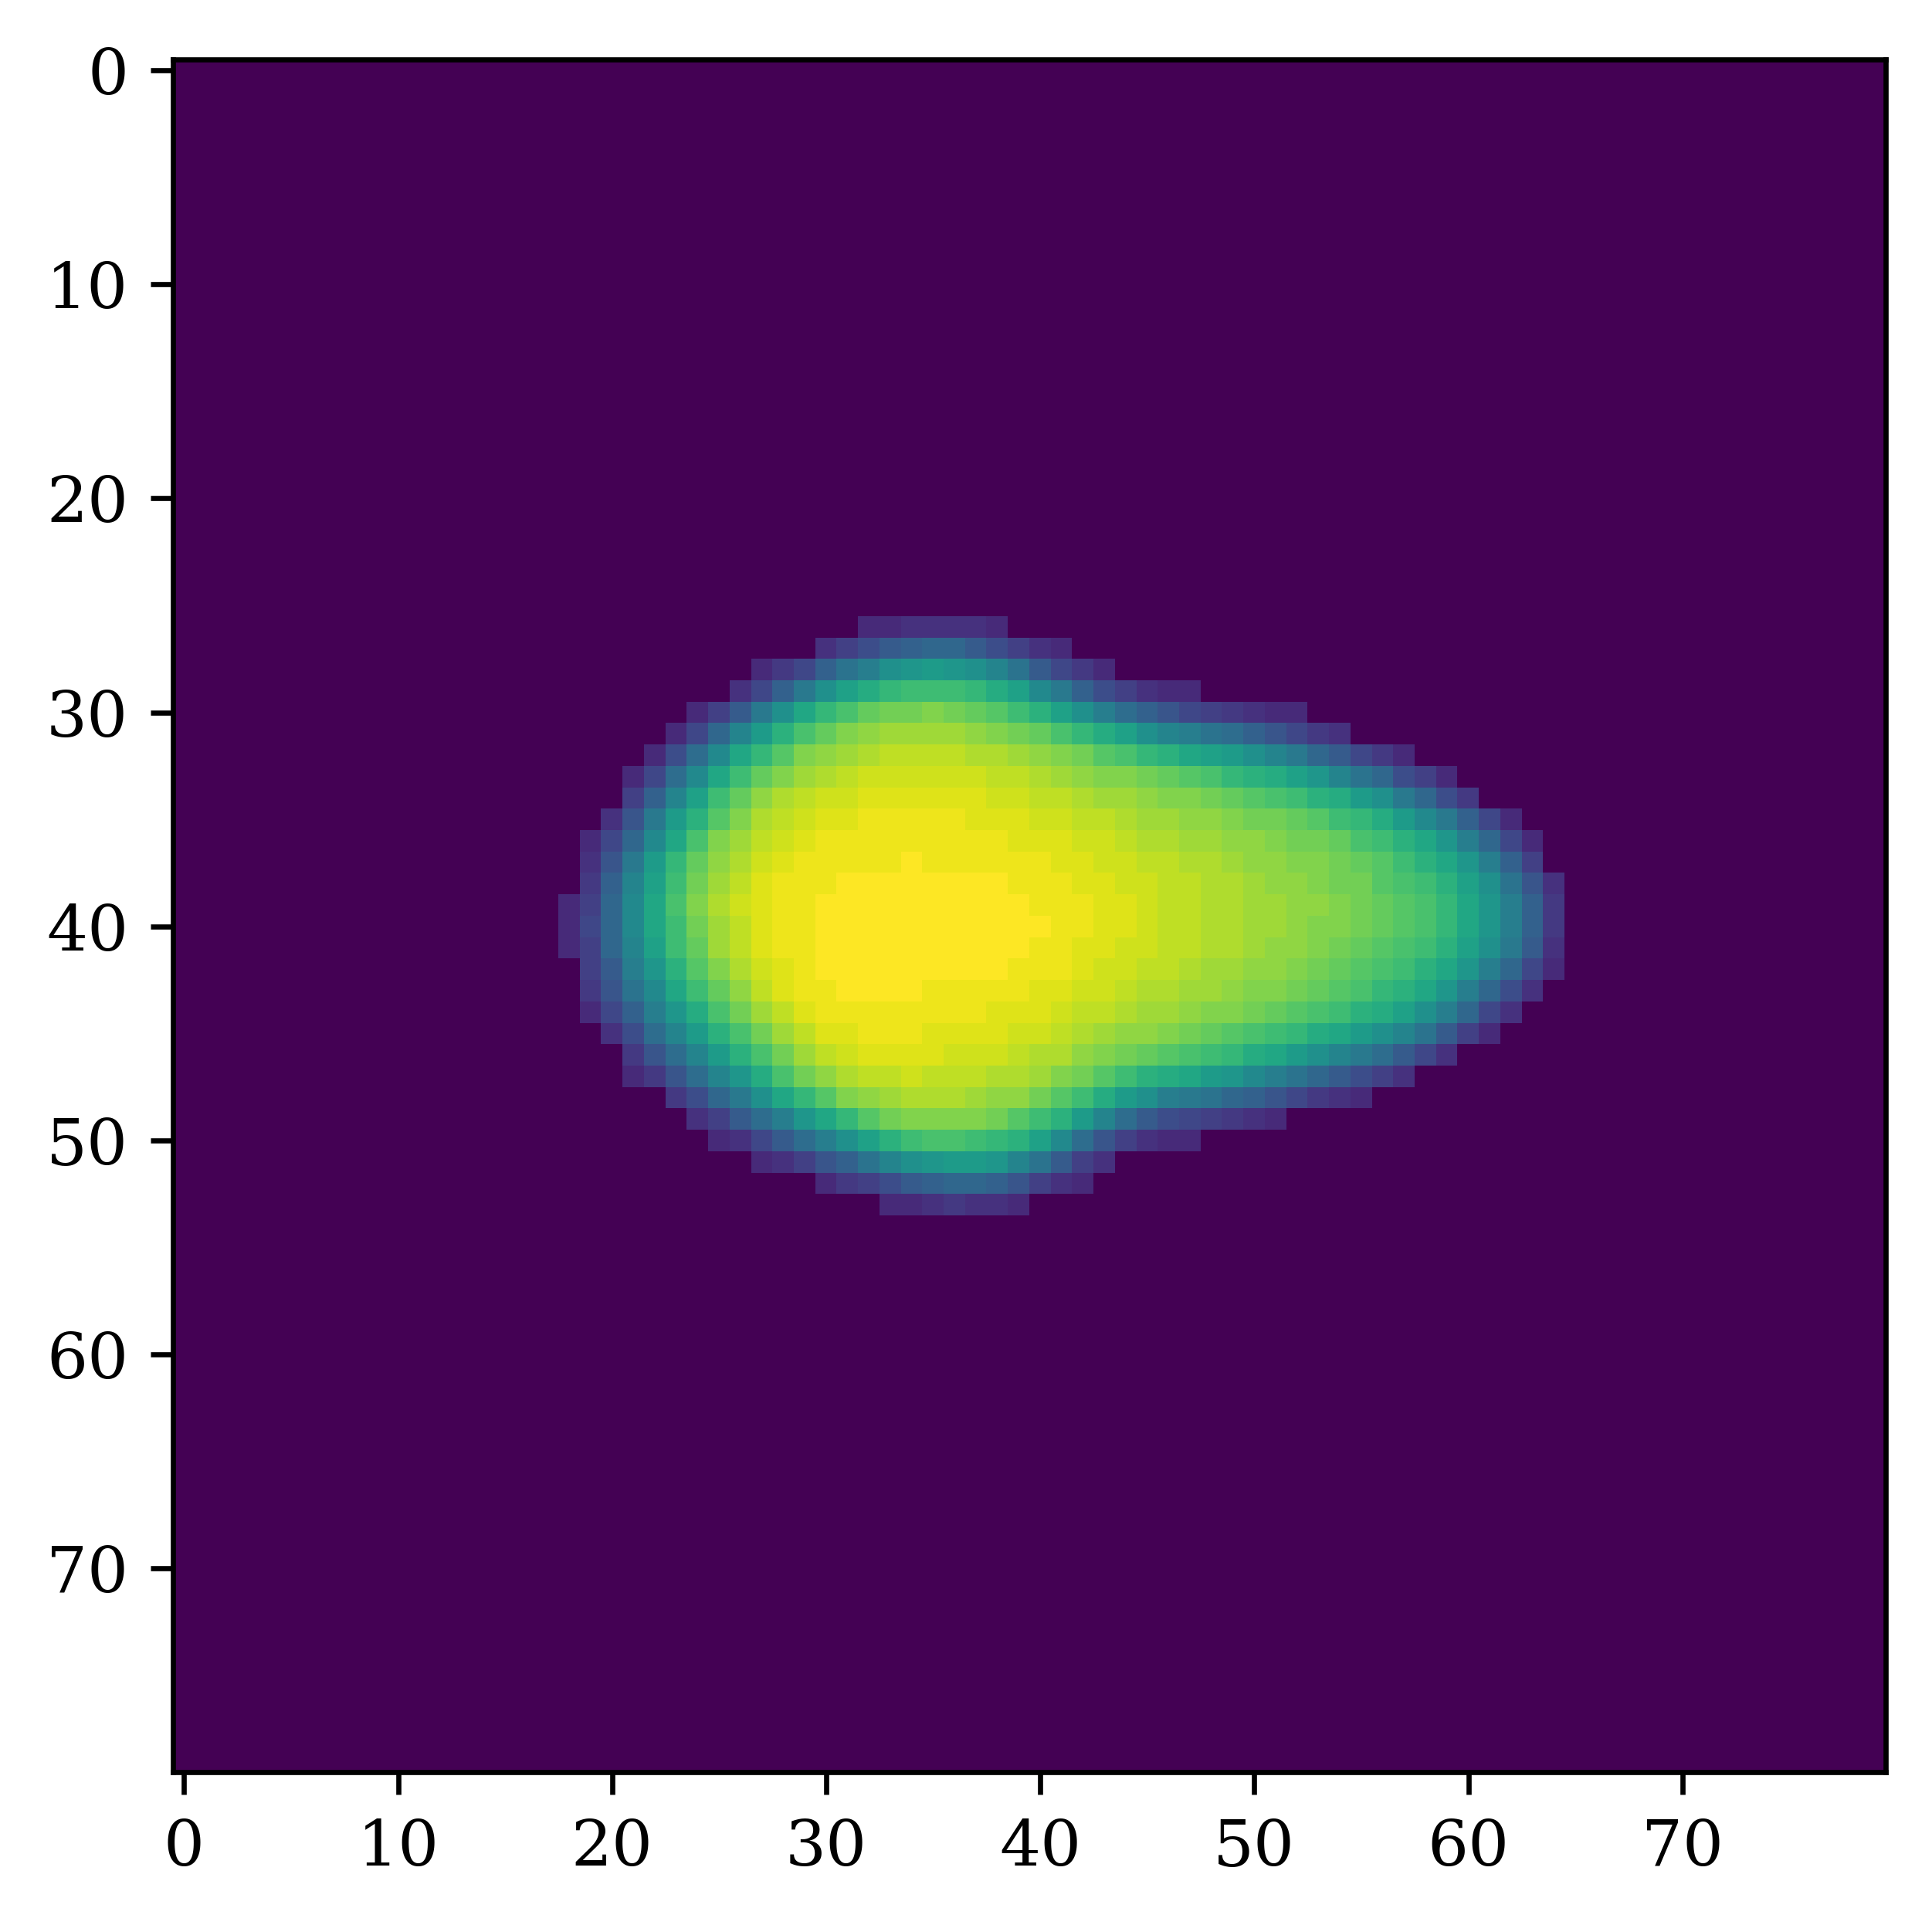

In [ ]:
plt.imshow(age_templates[103][list(age_templates[103].keys())[1]])

## Start the optimization process

In [ ]:
poses = joblib.load(training_paths.tps_training_data)

In [ ]:
sorted(poses)

[3,
 4,
 5,
 7,
 8,
 9,
 12,
 16,
 20,
 24,
 28,
 32,
 35,
 36,
 40,
 44,
 48,
 52,
 56,
 60,
 64,
 68,
 72,
 78,
 80,
 84,
 90,
 103]

In [ ]:
example_template = poses[12][list(poses[12].keys())[0]]
example_old = poses[103][list(poses[103].keys())[1]]

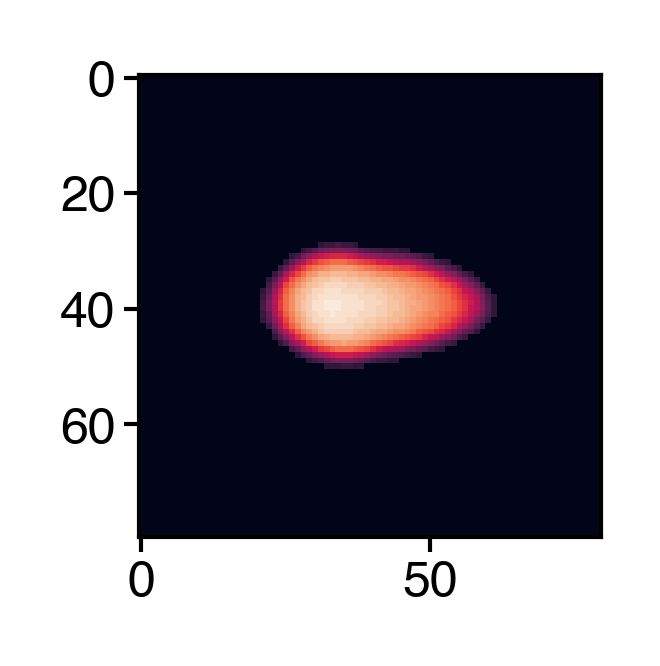

In [ ]:
figure(1, 1)
plt.imshow(example_template)

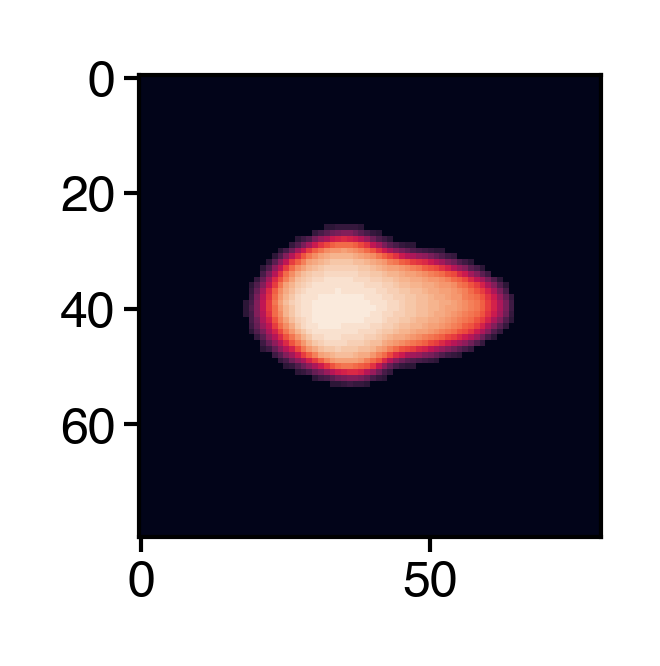

In [ ]:
figure(1, 1)
plt.imshow(example_old)

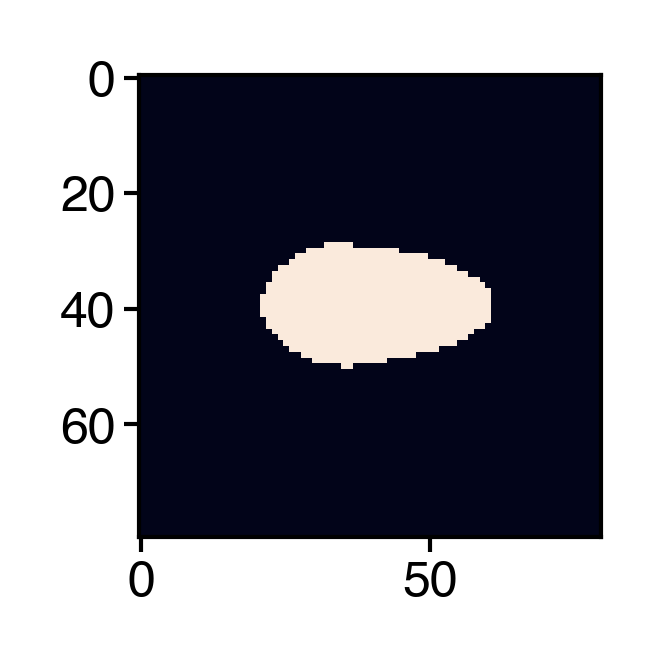

In [ ]:
figure(1, 1)
plt.imshow(example_template > 5)

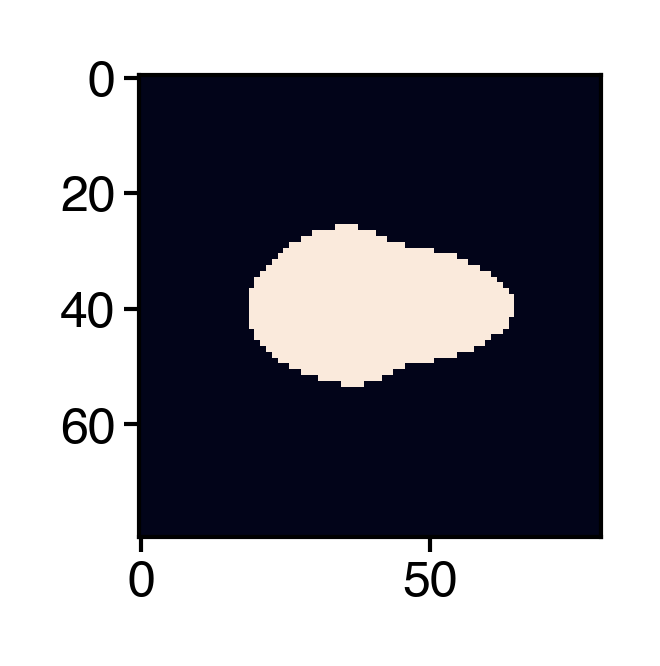

In [ ]:
figure(1, 1)
plt.imshow(example_old > 5)

In [ ]:
import torch
from itertools import product
from kornia.geometry.transform import scale

In [ ]:
# scale the template to the size of the old one
template = torch.tensor(example_template).view(1, 1, *example_template.shape).float()
target = torch.tensor(example_old).view(1, 1, *example_old.shape).float()

In [ ]:
scales = np.linspace(0.5, 2, 151)

mses = np.zeros((len(scales), len(scales)))

for i, (scale_x, scale_y) in enumerate(product(scales, scales)):
    scale_tensor = torch.tensor([scale_x, scale_y]).view(1, 2).float()
    scaled_template = scale(template, scale_tensor)
    # mses.flat[i] = torch.nn.functional.mse_loss(scaled_template, target).item()
    mses.flat[i] = torch.nn.functional.mse_loss((scaled_template > 5).float(), (target > 5).float()).item()

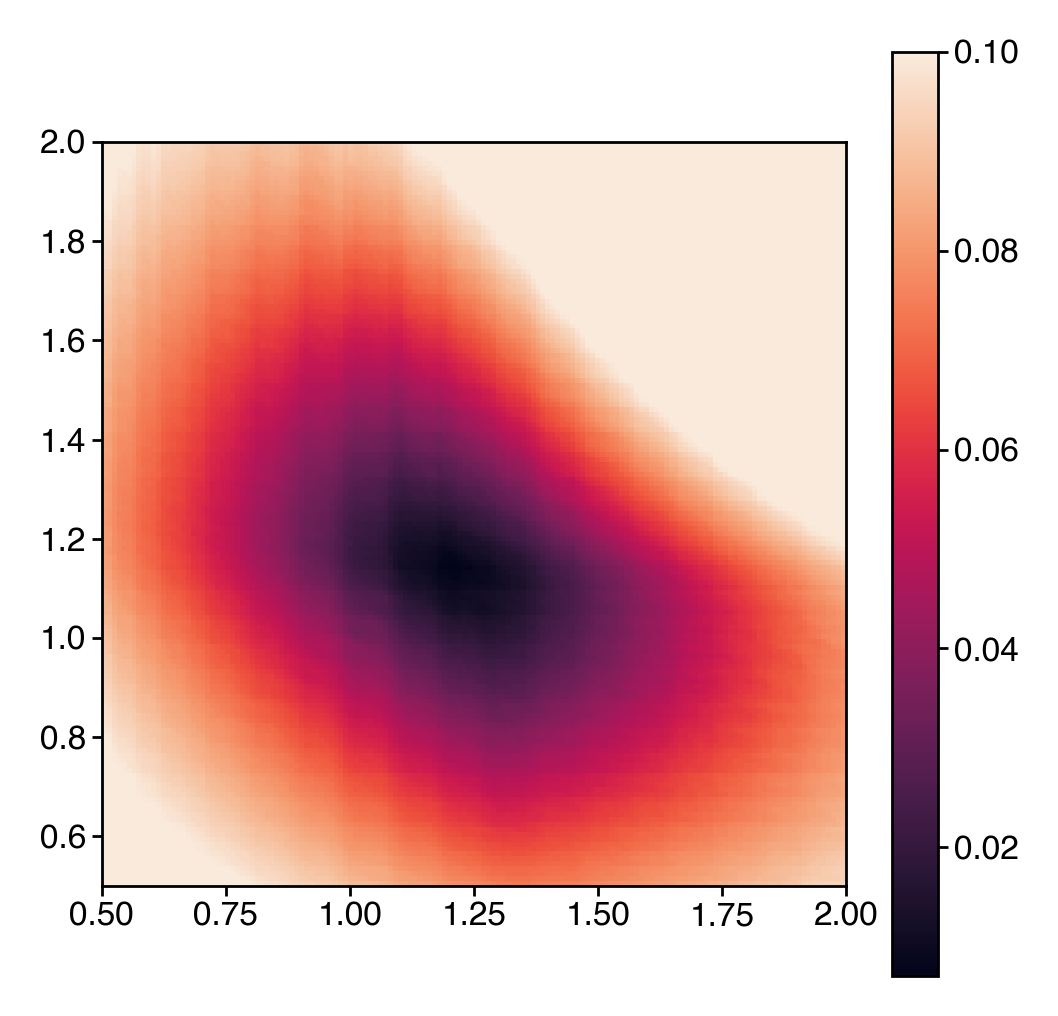

In [ ]:
plt.imshow(mses, extent=[scales[0], scales[-1], scales[0], scales[-1]], origin='lower', vmax=0.1, interpolation='none')
plt.colorbar()

In [ ]:
idx = np.unravel_index(np.argmin(mses), mses.shape)
scales[np.array(idx)]

array([1.14, 1.2 ])

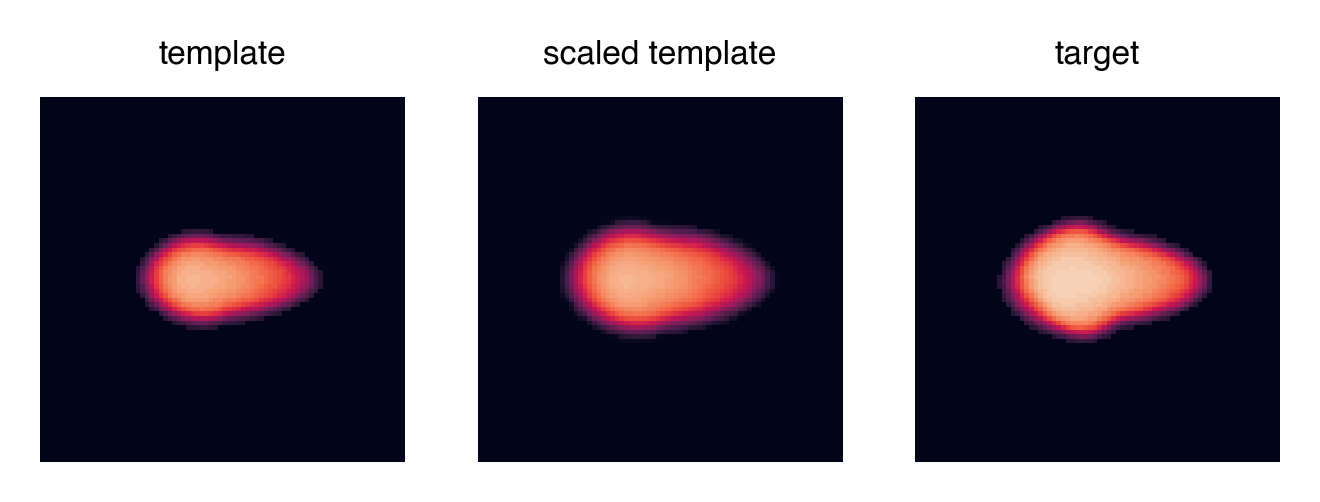

In [ ]:
scale_tensor = torch.tensor(scales[np.array(idx)]).view(1, 2).float()
scaled_template = scale(template, scale_tensor).squeeze().numpy()

fig, ax = plt.subplots(1, 3, figsize=(4, 3))
ax[0].imshow(template.squeeze(), vmax=45)
ax[1].imshow(scaled_template, vmax=45)
ax[2].imshow(target.squeeze(), vmax=45)
for a, title in zip(ax.flat, ['template', 'scaled template', 'target']):
    a.set_title(title)
    a.axis('off')

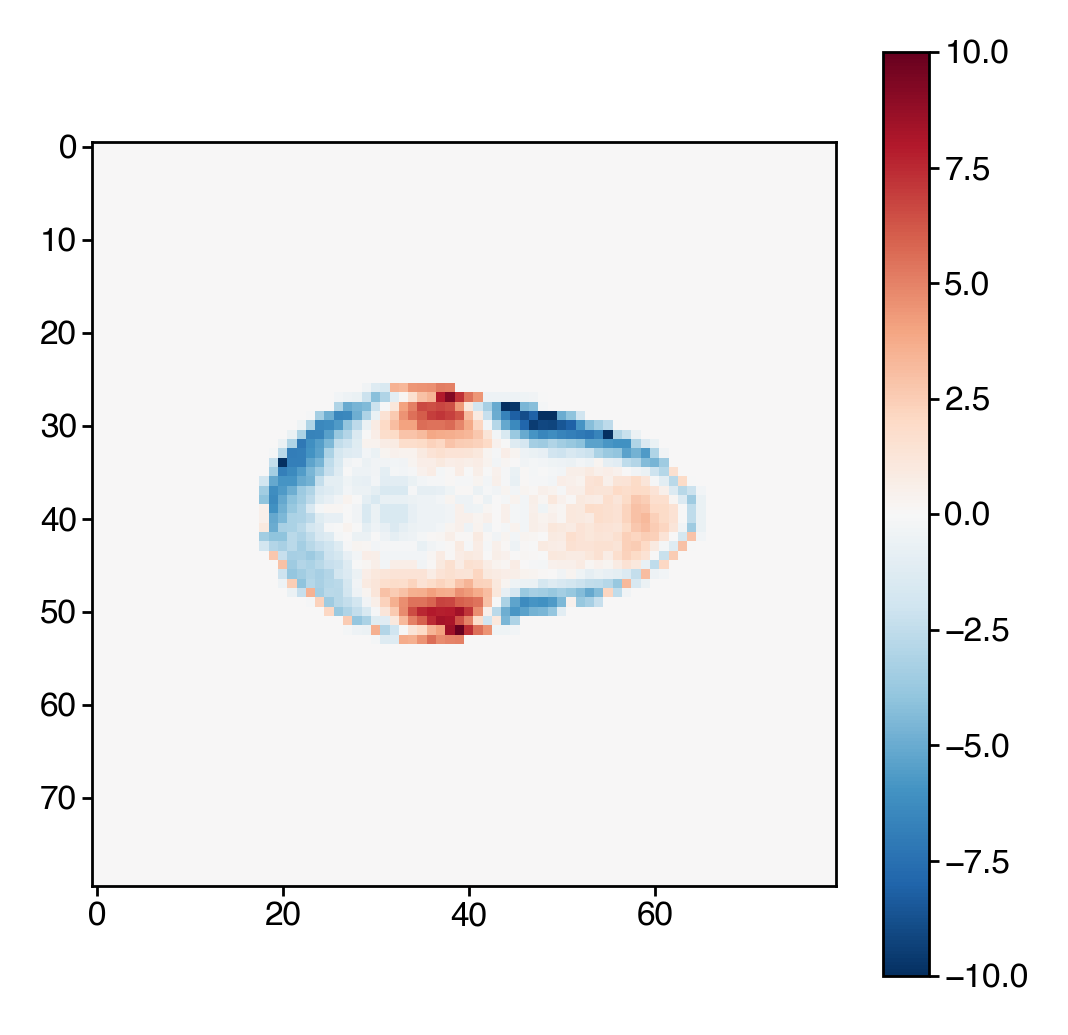

In [ ]:
# diff = target.squeeze().numpy() - (scaled_template * 1.15)
diff = target.squeeze().numpy() - (scaled_template + 4.5 * (scaled_template > 5))
plt.imshow(diff, cmap='RdBu_r', vmin=-10, vmax=10)
plt.colorbar()

## Set up TPS optimization code

Step 1. Make a meshgrid to sample from image 1

Step 2. Make a weight matrix that specifies the movement of the meshgrid to "match" the target

Step 3. Make a sub-sampled matrix that will code for changes in mouse height (like a piecewise linear transform)

Run an MSE optimization to turn the template into the target.

In [ ]:
import torch
from kornia.geometry.transform import scale
from kornia.geometry.transform import warp_image_tps, get_tps_transform, resize

In [ ]:
# pad movement vector
def pad_vector(v):
    return torch.nn.functional.pad(v, (1, 1, 1, 1), value=0)

In [ ]:
example_template = poses[12][list(poses[12].keys())[0]]
example_old = poses[103][list(poses[103].keys())[1]]

template = torch.tensor(example_template).view(1, 1, *example_template.shape).float()
target = torch.tensor(example_old).view(1, 1, *example_old.shape).float()

In [ ]:
grid_size = 6
grid = torch.meshgrid(torch.linspace(-0.5, 0.5, grid_size), torch.linspace(-0.5, 0.5, grid_size), indexing='ij')
grid = torch.stack(grid, dim=-1).view(1, -1, 2)

In [ ]:
movement_vector = torch.zeros(2, grid_size - 2, grid_size - 2, requires_grad=True)
scale_tensor = torch.tensor([1.0, 1.0], dtype=torch.float, requires_grad=True)
height_mtx = torch.ones(1, 1, 5, 8, requires_grad=True)
opt = torch.optim.AdamW([movement_vector, scale_tensor, height_mtx], lr=1e-2, weight_decay=1e-4)

# TODO: try adding heterometric scaling before tps
losses = []

pbar = tqdm(range(100))

for i in pbar:
    padded_vector = torch.transpose(pad_vector(movement_vector), 0, 2)
    kernel, affine = get_tps_transform(grid + padded_vector.reshape(1, -1, 2), grid)
    scaled_template = scale(template, scale_tensor.unsqueeze(0))
    out = warp_image_tps(scaled_template, grid, kernel, affine, align_corners=True)

    height_intermediate = resize(height_mtx, target.shape[-2:])

    loss = torch.nn.functional.mse_loss(out * height_intermediate, target)
    opt.zero_grad()
    loss.backward()
    opt.step()
    losses.append(loss.item())
    pbar.set_description(f'loss: {loss.item():.3f}')

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
scale_tensor

tensor([1.1586, 1.0922], requires_grad=True)

(0.0, 19.565940767154096)

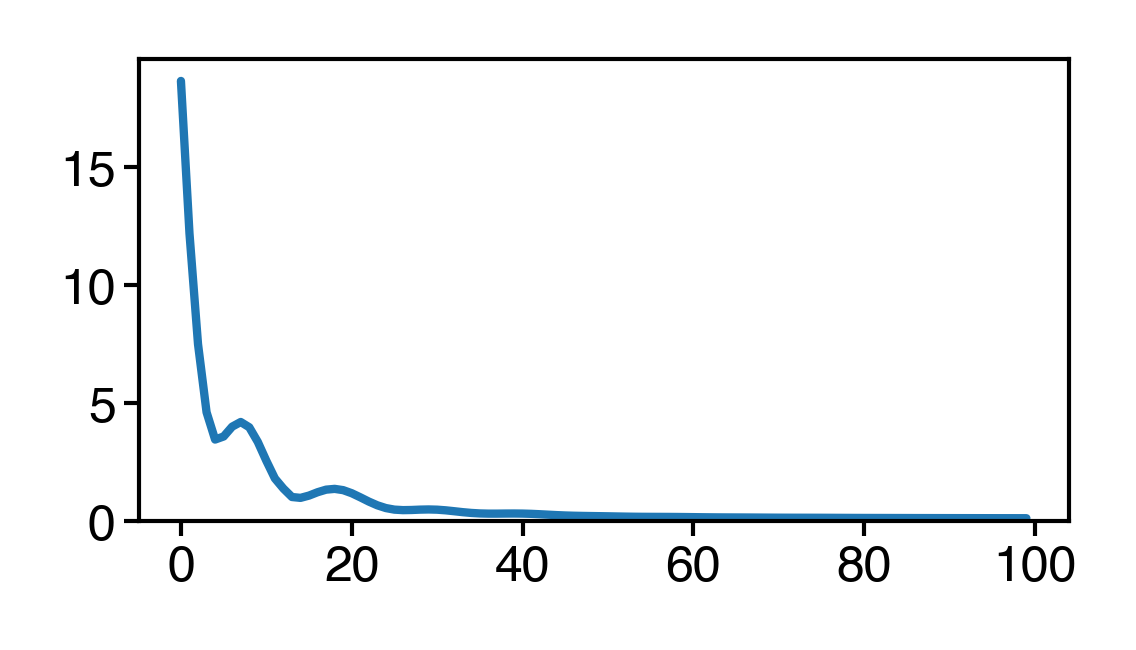

In [ ]:
fig = figure(2, 1)
plt.plot(losses)
plt.ylim(0, None)

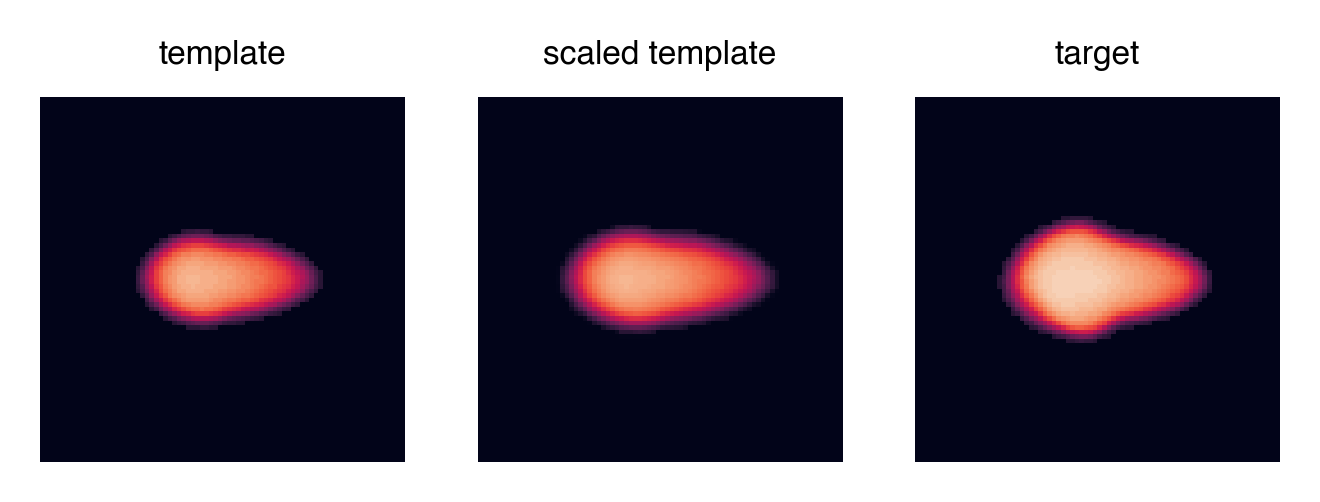

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(4, 3))
ax[0].imshow(template.squeeze(), vmax=45)
ax[1].imshow(scaled_template.squeeze().detach(), vmax=45)
ax[2].imshow(target.squeeze(), vmax=45)
for a, title in zip(ax.flat, ['template', 'scaled template', 'target']):
    a.set_title(title)
    a.axis('off')

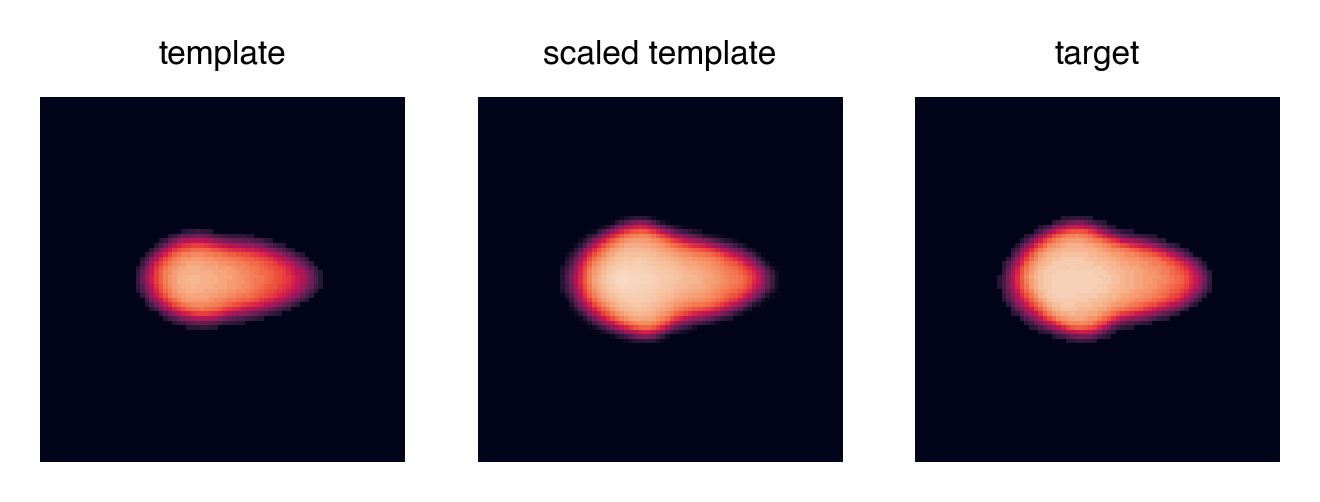

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(4, 3))
ax[0].imshow(template.squeeze(), vmax=45)
ax[1].imshow((out * height_intermediate).squeeze().detach(), vmax=45)
ax[2].imshow(target.squeeze(), vmax=45)
for a, title in zip(ax.flat, ['template', 'scaled template', 'target']):
    a.set_title(title)
    a.axis('off')

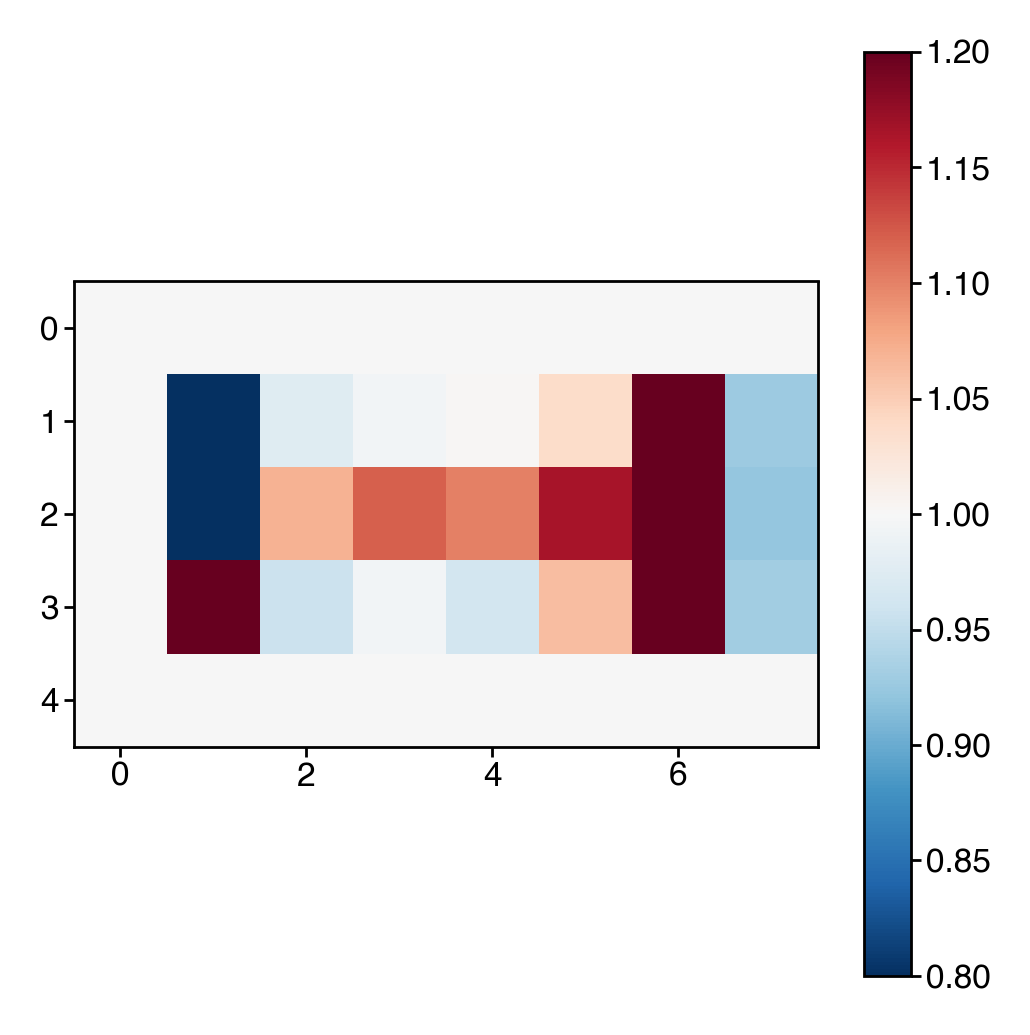

In [ ]:
plt.imshow(height_mtx.squeeze().detach(), interpolation='none', cmap='RdBu_r', vmin=0.8, vmax=1.2)
plt.colorbar()

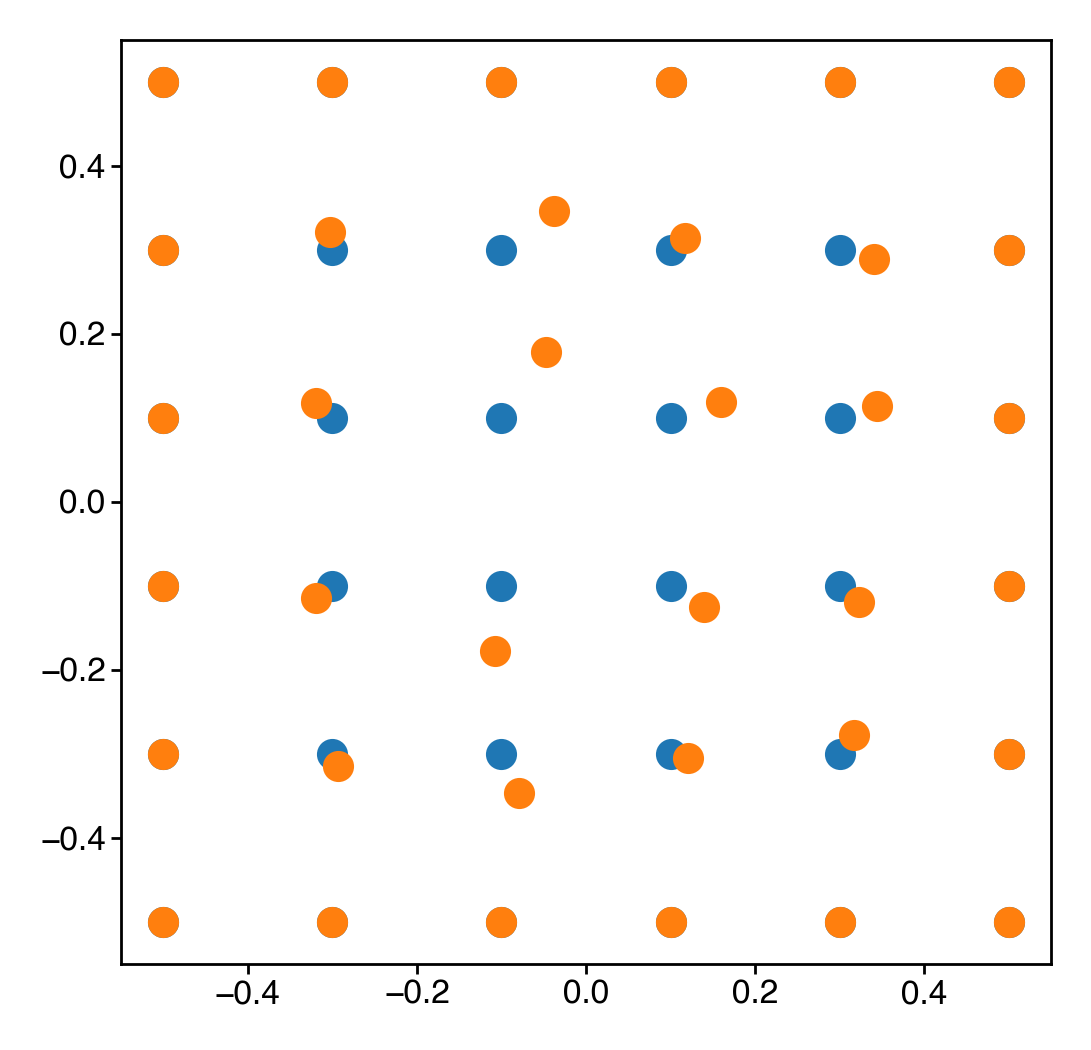

In [ ]:
g = grid.squeeze().numpy()
plt.scatter(*g.T)

padded_vector = torch.transpose(pad_vector(movement_vector), 0, 2).reshape(1, -1, 2)
moved_grid = (grid + padded_vector).detach().squeeze().numpy()

plt.scatter(moved_grid[..., 0], moved_grid[..., 1])